Сначала запускаем функцию выгружения памяти с видеокарты, иначе можно забыть выгрузить модель или паралелльно иметь загруженный ноутбук. Иногда в таких случаях её не хватает, и все зависает.

In [ ]:
import torch
with torch.no_grad():
    torch.cuda.empty_cache()

Загружаем все библиотеки за один раз, которые используются.

In [ ]:
import numpy as np
import pandas as pd
import torchaudio
import os
import sys
import torchaudio
import librosa
import IPython.display as ipd
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import random
import wandb
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric
from transformers import AutoConfig, Wav2Vec2Processor
from dataclasses import dataclass
from typing import Optional, Tuple
from transformers.file_utils import ModelOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from typing import Dict, List, Optional, Union
from transformers import EvalPrediction
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import classification_report
from IPython.display import Audio, display
from datasets import Dataset
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2PreTrainedModel
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2Model


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
wandb.login()

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: kameshmihail (thpmihail). Use `wandb login --relogin` to force relogin


True

In [ ]:
os.environ["WANDB_PROJECT"]="english_accent_classifier_test"

Датасет сортирован по папкам, наименование которых соответствует типу акцента, по которому идет классификация. Для создания датасета сначала инициализируем пустой 3 мерный список и заполним его. Каждому индексу соответствует название файла, его путь, который можно потом будет использовать для загрузки файла через библиотеки и сам акцент.

In [ ]:
dataset = []

for x in tqdm(Path("/home/thp/diplom/audio/").glob("**/*.wav")):
    file = str(x).split('/')[-1].split('.')[0]
    label = str(x).split('/')[-2]
    dataset.append({
            "file_name": file,
            "path_to_file": x,
            "accent": label
        })

9646it [00:00, 130384.75it/s]


Конвертируем полученный список в Pandas.

In [ ]:
df = pd.DataFrame(dataset)
dataset = []
df.head()

,file_name,path_to_file,accent
0,mandarin15_7,/home/thp/diplom/audio/chinese/mandarin15_7.wav,chinese
1,cantonese4_7,/home/thp/diplom/audio/chinese/cantonese4_7.wav,chinese
2,mandarin26_3,/home/thp/diplom/audio/chinese/mandarin26_3.wav,chinese
3,mandarin31_4,/home/thp/diplom/audio/chinese/mandarin31_4.wav,chinese
4,wu2_4,/home/thp/diplom/audio/chinese/wu2_4.wav,chinese


Для визуализации посмотрим сколько акцентов каждого типа.

In [ ]:
print("Labels: ", df["accent"].unique())
print()
df.groupby("accent").count()[["path_to_file"]]

Labels:  ['chinese' 'slavic' 'spanish' 'semitic' 'english' 'indoiranian']



,path_to_file
accent,
chinese,1568
english,1680
indoiranian,1414
semitic,1687
slavic,1610
spanish,1687


<BarContainer object of 6 artists>

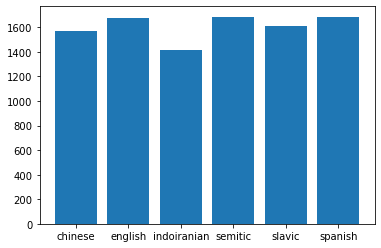

In [ ]:
plt.bar(*np.unique(df["accent"], return_counts=True))

Разделим датасет на 3 части - train / validation / test в пропорциях 70%/15%/15% соответственно.

In [ ]:
train, validation, test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.85*len(df))])

/home/thp/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Посмотрим получившуюся их размерность.

In [ ]:
print(train.shape)
print(validation.shape)
print(test.shape)

(6752, 3)
(1447, 3)
(1447, 3)


Обнулим индексы, чтобы они шли по порядку. Сейчас они несколько сломаны после разбиения даты на 3 части.

In [ ]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

Опишем функцию перевода wav файла в аудио массив, который используется для подачи на вход модели.

In [ ]:
def ConvWav2Array(path):
    arr, sampling_rate = torchaudio.load(path) # Загрузка файла, получение массива и самплинг рейта.
    sample = torchaudio.transforms.Resample(sampling_rate, 16000) # Модель использует самплинг рейт 16000, делаем ресампл
    array = sample(arr).squeeze().numpy() # Убираем одномерные элементы массива
    return array

Создаем списки с аудио массивами, соответствующими разбитым датасетам.

In [ ]:
data_validation = []
for x in range (1447) :
    data_validation.append({
            "array": ConvWav2Array(validation["path_to_file"][x])
        })

In [ ]:
data_train = []
for x in range (6752) :
    data_train.append({
            "array": ConvWav2Array(train["path_to_file"][x])
        })

In [ ]:
data_test = []
for x in range (1447) :
    data_test.append({
            "array": ConvWav2Array(test["path_to_file"][x])
        })

Переводим датасеты в huggingface датасеты, для этого убираем колонку path_to_file, потому что она не конвертируется.

In [ ]:
train = train.drop(columns=['path_to_file'])
test = test.drop(columns=['path_to_file'])
validation = validation.drop(columns=['path_to_file'])

dataset_train = Dataset.from_pandas(train)
dataset_test = Dataset.from_pandas(test)
dataset_validation = Dataset.from_pandas(validation)

Добавляем к получившимся датасетам соответствующие колонки звуковых массивов. И освобождаем память.

In [ ]:
dataset_train = dataset_train.add_column("sound_array", data_train)
dataset_test = dataset_test.add_column("sound_array", data_test)
dataset_validation = dataset_validation.add_column("sound_array", data_validation)

In [ ]:
data_test = []
data_validation = []
data_train = []
train = []
test = []
validation = []

Для визуализации покажем 5 случайных аудиоклипов с помощью полученного звукового массива.

In [ ]:
for _ in range(5):
    rand_idx = random.randint(0, len(dataset_train) - 1)
    example = dataset_train[rand_idx]
    audio = example["sound_array"]
    accent = example["accent"]
    file_name = example["file_name"]
    print(f'Accent: {accent}')
    print(f'file_name: {file_name}')
    display(Audio(audio["array"], rate=16000))
    print()

Accent: semitic
file_name: arabic163_1



Accent: indoiranian
file_name: hindi18_5



Accent: spanish
file_name: spanish236_6



Accent: english
file_name: english142_3



Accent: slavic
file_name: russian11_5


Переведем лейблы в индексы для тренировки. Сначала сделаем их список и его детерминируем сортировкой.

In [ ]:
all_labels = dataset_train.unique("accent")
all_labels.sort()
num_labels = len(all_labels)

Скачиваем и немного меняем паметры модели. В статье, которой я читал (https://arxiv.org/abs/2306.06524) и в ходе личных экспериментов сделаны мною выводы, что хотя в модели 12 слоев, она разработана для ASR - восприятия акцентированной речи, что совсем не факт полностью совпадает с задачей классификации акцентов. Максимальная точность вроде бы получается после 8 слоев, значит убираем ненужные 4.

In [ ]:
config = AutoConfig.from_pretrained("facebook/wav2vec2-base-960h") # 960часов это стандартная Wav2Vec2 модель.
setattr(config, 'pooling_mode', "mean")
setattr(config, 'num_hidden_layers', 8)
setattr(config, 'num_labels', len(all_labels) )
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h",)
wav2vec2_sampling_rate = processor.feature_extractor.sampling_rate

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Опишем функцию для маппинга датасета. Сделаем новую колонку с лейблом, соответствующим акцентам и применим ко всему датасету processor функцию, нужную для дальнейшей тренировки.

In [ ]:
def Wav2Vec2_process(data):
    inputs = [x["array"] for x in data["sound_array"]]
    goals = [all_labels.index(label) for label in data["accent"]]
    proc = processor(inputs, sampling_rate=wav2vec2_sampling_rate)
    proc["labels"] = list(goals)

    return proc

Применим эту фукнцию для всех датасетов и освободим память.

In [ ]:
train_dataset = dataset_train.map(
    Wav2Vec2_process,
    batch_size=10,
    batched=True,
    num_proc=1
)

Map:   0%|          | 0/6752 [00:00<?, ? examples/s]

In [ ]:
dataset_train = []

In [ ]:
eval_dataset = dataset_validation.map(
    Wav2Vec2_process,
    batch_size=10,
    batched=True,
    num_proc=1
)

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

In [ ]:
dataset_validation = []

In [ ]:
test_dataset = dataset_test.map(
    Wav2Vec2_process,
    batch_size=10,
    batched=True,
    num_proc=1
)

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

In [ ]:
dataset_test = []

In [ ]:
dataset_test_2 = load_dataset('TheHolyPacman/train_dataset_2', split='train')

In [ ]:
test_dataset_2 = dataset_test_2.map(
    Wav2Vec2_process,
    batch_size=10,
    batched=True,
    num_proc=1
)

In [ ]:
dataset_test_2 = []

In [ ]:
test_dataset_2

Dataset({
    features: ['file_name', 'accent', 'sound_array', 'input_values', 'labels'],
    num_rows: 419
})

Wav2Vec2 дефолтно имеет выход как транскрипция акцентированной речи. Нам нужна классификация, для чего нужно сделать выходной слой с софтмаксом. Довольно популярная модель Bert имеет в документации функцию для классификации последовательностей - BertForSequenceClassification. Она отлично применяется для текущей проблемы, если её немного отредактировать. Возьмем функцию BertForSequenceClassification, отредактируем в Wav2Vec2Classification и возьмем функцию SequenceClassifierOutput как есть.

https://github.com/huggingface/transformers/blob/main/src/transformers/modeling_outputs.py
https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py

In [ ]:
@dataclass
class SequenceClassifierOutput(ModelOutput):
    """
    Base class for outputs of sentence classification models.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (`torch.FloatTensor` of shape `(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
class Wav2Vec2Classification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.dropout = nn.Dropout(config.final_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_values: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )




        hidden_states = outputs[0]
        hidden_states = torch.mean(hidden_states, dim=1)
        logits = self.classifier(hidden_states)
        loss = None


        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


Возьмем готовый datacollator wav2vec с официального ресурса : https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

Загружаем модель с конфигурацией для тренировки.

In [ ]:
model = Wav2Vec2Classification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    config=config,
)

Some weights of Wav2Vec2Classification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'classifier.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Определяем функции для вычисления метрик во время тренировки.

In [ ]:
def custom_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    #metric5 = load_metric("roc_auc", "multilabel")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels, average="macro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="macro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="macro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    #roc_auc = metric5.compute(prediction_scores=predictions, references=labels, multi_class="ovo")["roc_auc"]


    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

Выбираем аргументы для тренировки. Адафактор и бач сайз 1 не идеальны, но что-то больше не выдерживает моя видеокарта.

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/wav2vec2-accent",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    optim="adafactor",
    evaluation_strategy="steps",
    num_train_epochs=25,
    fp16=True,
    save_steps=150,
    eval_steps=150,
    logging_steps=150,
    learning_rate=1e-4,
    report_to="wandb",
    run_name="wav2vec2-base_test",
)

Инициализируем тренер и начинаем тренировку на 3 эпохах. Получаем тренированную модель и метрики в процессе тренировки. При эпохах больше 3 метрики почти перестают увеличиваться, потенциально можно как-то сделать график метрик на тестовом сете и остановить до того, как начнется перетренировка

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True),
    tokenizer = processor.feature_extractor,
    compute_metrics=custom_metrics,
)

In [ ]:
trainer.train()

/home/thp/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,1.587200,1.160050,0.573967,0.520405,0.501169,0.541120
300,1.221200,0.942021,0.705399,0.665483,0.661545,0.668970
450,0.996100,0.759365,0.749176,0.731813,0.730563,0.738770
600,0.842400,0.643378,0.810359,0.767220,0.772029,0.777471
750,0.692000,0.594686,0.812524,0.790576,0.789253,0.796130
900,0.563500,0.607648,0.812636,0.800555,0.800545,0.805114
1050,0.516300,0.670085,0.818971,0.787019,0.782127,0.788528
1200,0.399400,0.537148,0.842596,0.827630,0.829565,0.834140
1350,0.365800,0.700564,0.833631,0.799023,0.791843,0.797512
1500,0.318800,0.571499,0.859499,0.840874,0.844364,0.849343


/tmp/ipykernel_2268/1923817105.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("precision")
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next ma

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the n

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home

/home/thp/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/h

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next ma

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the n

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home

/home/thp/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/h

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next ma

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the n

TrainOutput(global_step=5275, training_loss=0.2810839867535361, metrics={'train_runtime': 22800.2584, 'train_samples_per_second': 7.403, 'train_steps_per_second': 0.231, 'total_flos': 4.4792436004325985e+18, 'train_loss': 0.2810839867535361, 'epoch': 25.0})

Сохраняем текущую модель, смотрим на метрики не тестовом сете и валидейшен сете с помощью встроенных в тренер функций.

In [ ]:
model.save_pretrained("/home/thp/diplom/models/model_18", from_pt = True)

In [ ]:
evaluations = trainer.evaluate(eval_dataset=test_dataset)

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this me

In [ ]:
evaluations_biased = trainer.evaluate(eval_dataset=eval_dataset)

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this me

Метрики на eval_data

In [ ]:
evaluations_biased

{'eval_loss': 0.7521753907203674,
 'eval_precision': 0.8934945332270612,
 'eval_recall': 0.8888787957065197,
 'eval_f1': 0.8901328305273366,
 'eval_accuracy': 0.8914996544574982,
 'eval_runtime': 59.0671,
 'eval_samples_per_second': 24.498,
 'eval_steps_per_second': 24.498,
 'epoch': 25.0}

Метрики на test_data

In [ ]:
evaluations

{'eval_loss': 0.7481831312179565,
 'eval_precision': 0.9028681656705011,
 'eval_recall': 0.8969837181764443,
 'eval_f1': 0.8977569613845812,
 'eval_accuracy': 0.8984105044920525,
 'eval_runtime': 54.9681,
 'eval_samples_per_second': 26.324,
 'eval_steps_per_second': 26.324,
 'epoch': 25.0}

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
predictions = trainer.predict(test_dataset)
prediction_labels = np.argmax(predictions.predictions, axis=-1)

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this me

In [ ]:
#'chinese', 'english', 'indoiranian', 'semitic', 'slavic', 'spanish'
idx_to_label = {
    0: "chinese",
    1: "english",
    2: "indoiranian",
    3: "semitic",
    4: "slavic",
    5: "spanish"
}

Confusion Matrix на eval сете.

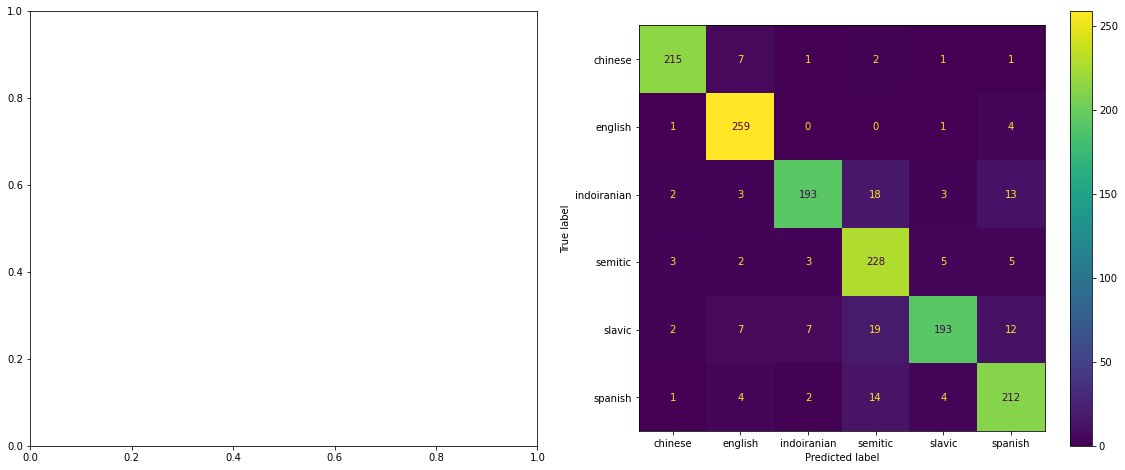

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ConfusionMatrixDisplay.from_predictions(test_dataset['labels'], prediction_labels, display_labels=list(idx_to_label.values()), ax=axes[1])

Таблица метрик по классам на eval сете.

In [ ]:
print(classification_report(test_dataset['labels'], prediction_labels, target_names=list(idx_to_label.values())))

              precision    recall  f1-score   support

     chinese       0.96      0.95      0.95       227
     english       0.92      0.98      0.95       265
 indoiranian       0.94      0.83      0.88       232
     semitic       0.81      0.93      0.87       246
      slavic       0.93      0.80      0.86       240
     spanish       0.86      0.89      0.88       237

    accuracy                           0.90      1447
   macro avg       0.90      0.90      0.90      1447
weighted avg       0.90      0.90      0.90      1447



In [ ]:
predictions = trainer.predict(eval_dataset)
prediction_labels = np.argmax(predictions.predictions, axis=-1)

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this me

Confusion Matrix на eval сете.

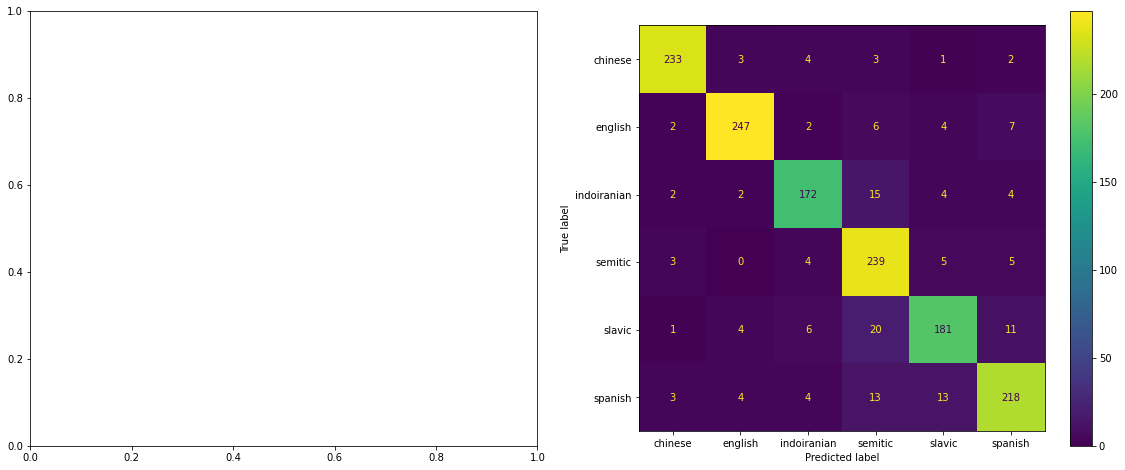

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ConfusionMatrixDisplay.from_predictions(eval_dataset['labels'], prediction_labels, display_labels=list(idx_to_label.values()), ax=axes[1])

Таблица метрик по классам на eval сете.

In [ ]:
print(classification_report(eval_dataset['labels'], prediction_labels, target_names=list(idx_to_label.values())))

              precision    recall  f1-score   support

     chinese       0.95      0.95      0.95       246
     english       0.95      0.92      0.94       268
 indoiranian       0.90      0.86      0.88       199
     semitic       0.81      0.93      0.87       256
      slavic       0.87      0.81      0.84       223
     spanish       0.88      0.85      0.87       255

    accuracy                           0.89      1447
   macro avg       0.89      0.89      0.89      1447
weighted avg       0.89      0.89      0.89      1447



In [ ]:
predictions = trainer.predict(test_dataset_2)
prediction_labels = np.argmax(predictions.predictions, axis=-1)

/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/thp/.local/lib/python3.10/site-packages/datasets/load.py:769: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this me

Confusion Matrix на альтернативном сете.

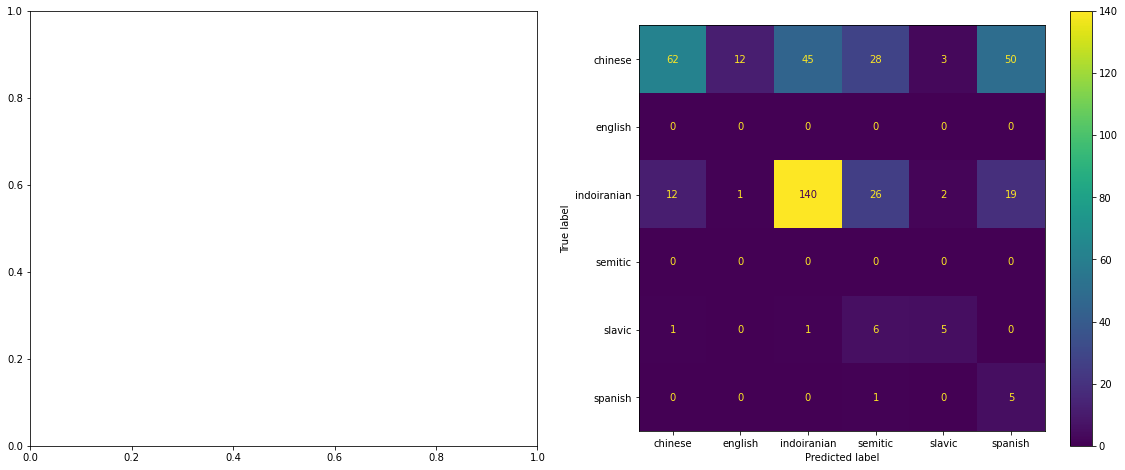

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ConfusionMatrixDisplay.from_predictions(test_dataset_2['labels'], prediction_labels, display_labels=list(idx_to_label.values()), ax=axes[1])

Таблица метрик по классам на альтернативном сете.

In [ ]:
print(classification_report(test_dataset_2['labels'], prediction_labels, target_names=list(idx_to_label.values())))

              precision    recall  f1-score   support

     chinese       0.83      0.31      0.45       200
     english       0.00      0.00      0.00         0
 indoiranian       0.75      0.70      0.73       200
     semitic       0.00      0.00      0.00         0
      slavic       0.50      0.38      0.43        13
     spanish       0.07      0.83      0.13         6

    accuracy                           0.51       419
   macro avg       0.36      0.37      0.29       419
weighted avg       0.77      0.51      0.58       419



/home/thp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_dataset_2.push_to_hub("TheHolyPacman/test_dataset_2_mod")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]